In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

In [2]:
users_data = pd.read_excel('POHR_Bridge_Frequent_Users_Jul2021_Jun2022.xlsx')

In [3]:
individual_pre = users_data[users_data.Acct_Type.str.lower() == "individual pre-paid"].dropna().copy()

# Average number of trips taken each month over the two year period
individual_pre['monthly_avg_trips'] = individual_pre.Total_POHR / 24

# Monthly bills
individual_pre['monthly_cost'] = individual_pre.monthly_avg_trips * 1.75

# Sort monthly bills and cumulatively sum them to get the portion of the total for each one
individual_pre = individual_pre.sort_values('monthly_cost')
individual_pre['cumulative_cost'] = individual_pre.monthly_cost.cumsum()



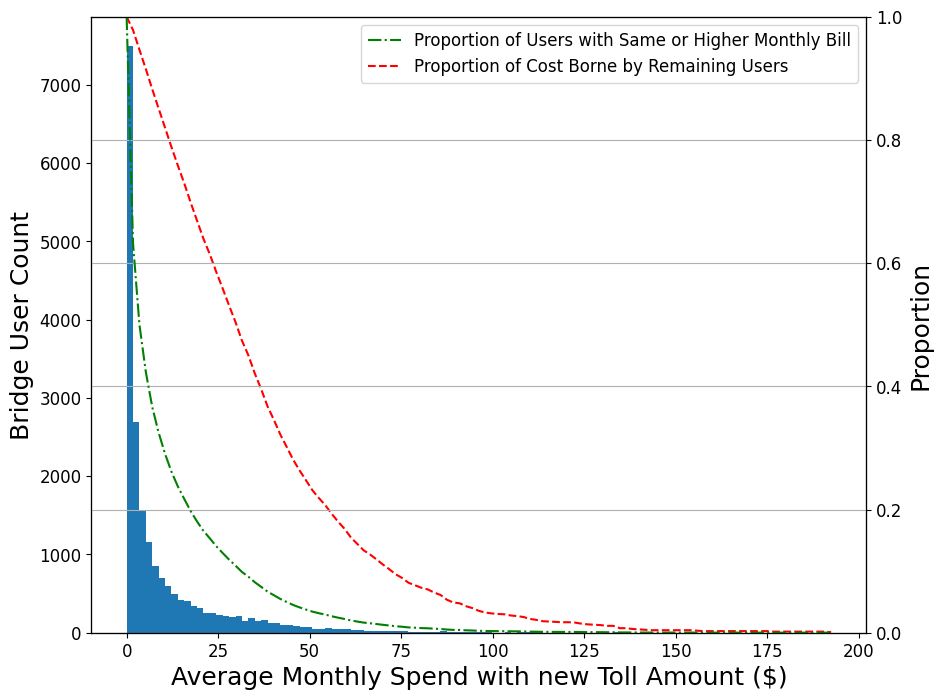

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
histogram = ax.hist(individual_pre.monthly_cost, bins=list(np.arange(0, max(individual_pre.monthly_cost), 1.75)))
ax.set_ylabel('Bridge User Count', fontsize=18)
ax.set_xlabel('Average Monthly Spend with new Toll Amount ($)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)


cum_by_edge = [0]
proportion_users_remaining = [1.0]
for edge in histogram[1][1:]:
    counts_included = individual_pre.cumulative_cost[individual_pre.monthly_cost < edge]
    cum_by_edge.append(counts_included.iloc[-1])
    proportion_users_remaining.append((1 - len(counts_included)/individual_pre.shape[0]))

total_income = individual_pre.cumulative_cost.max()
cumulative_proportion = [v/total_income for v in cum_by_edge]

ax2 = ax.twinx()
proportion_cost_line, = ax2.plot(histogram[1], [1 - p for p in cumulative_proportion], '--r')
proportion_cost_line.set_label('Proportion of Cost Borne by Remaining Users')
ax2.set_ylim([0, 1])
ax2.yaxis.set_ticks([])
ax3 = ax2.twinx()
ax3.set_ylim([0, 1])
proportion_users_line, = ax3.plot(histogram[1], proportion_users_remaining, '-.g')
proportion_users_line.set_label('Proportion of Users with Same or Higher Monthly Bill')
ax3.set_ylabel(ylabel='Proportion', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.grid()

plt.legend(handles=[proportion_users_line, proportion_cost_line], fontsize=12)

In [5]:
def get_bill_break_for_user_proportion(proportion):
    return np.interp(proportion, proportion_users_remaining[::-1], histogram[1][::-1])

def get_proportion_of_bridge_cost_born_by_remaining_users_from_cost(cost):
    return np.interp(cost, histogram[1],  [1 - p for p in cumulative_proportion])

In [7]:
cost_by_percentage_users = pd.DataFrame(
    {'Percentage Of Users': [90, 70, 50, 30, 20, 10, 5, 2.5, 1]}
)
cost_by_percentage_users['Average Monthly Bill Break ($)'] = cost_by_percentage_users['Percentage Of Users'].apply(
    lambda x: np.round(get_bill_break_for_user_proportion(x/100), 2))
cost_by_percentage_users['Percent of Bridge Cost Borne at or above Bill Break'] = cost_by_percentage_users['Average Monthly Bill Break ($)'].apply(
    lambda x: np.round(get_proportion_of_bridge_cost_born_by_remaining_users_from_cost(x), 2)*100)
print(cost_by_percentage_users.to_markdown())

|    |   Percentage Of Users |   Average Monthly Bill Break ($) |   Percent of Bridge Cost Borne at or above Bill Break |
|---:|----------------------:|---------------------------------:|------------------------------------------------------:|
|  0 |                  90   |                             0.48 |                                                    99 |
|  1 |                  70   |                             1.43 |                                                    98 |
|  2 |                  50   |                             3.5  |                                                    95 |
|  3 |                  30   |                            10.01 |                                                    83 |
|  4 |                  20   |                            17.26 |                                                    70 |
|  5 |                  10   |                            31.27 |                                                    48 |
|  6 |                  